<a href="https://colab.research.google.com/github/gadm21/AI/blob/master/AutoEncoder_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import cv2 
import numpy as np
from skimage.util import random_noise
from skimage import feature 
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
import os 
import imutils 
from google.colab.patches import cv2_imshow


import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import PIL
import random

# Functions

In [61]:
#show many images 
def show_images(images, labels = None):
  plt.figure(figsize=(30,20))
  columns = 4
  for i, image in enumerate(images):
      if isinstance(image, str): image = read_image(image)
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
      plt.axis('off')
      if labels is not None : plt.title(str(labels[i]))

#show one image
def show_image(image):
  if isinstance(image, str) : image = read_image(image) 
  cv2_imshow(image)

#take the image path and returns an image
def read_image(image_path):
    image = cv2.imread(image_path)
    return cv2.resize(image, (1280//2, 720//2))

#converts the image from RGB to gray scale
def to_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#converts the image from RGB or gray scale to hsv color space 
def to_hsv(image):
    if len(image.shape)==3:
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype(np.uint8) 
    else: return None

def adjust_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if value > 0 : 
      lim = 255 - value
      v[v > lim] = 255
      v[v <= lim] += value
    elif value < 0 :
      lim = abs(value)
      v[v <= lim] = 0 
      v[v > lim] -= lim

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img


def adjust_paleness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    if value > 0 : 
      lim = 255 - value
      s[s > lim] = 255
      s[s <= lim] += value
    elif value < 0 :
      lim = abs(value)
      s[s <= lim] = 0 
      s[s > lim] -= lim

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def blur(image, kernel_size = 10):
  return cv2.blur(image, (kernel_size, kernel_size))

def add_noise(img):
    noise = np.random.randn(img.shape) * 0.2
    noisy_img = img + noise
    return noisy_img
  
class noise():

  def s_p_noise( image, s_vs_p = 0.5, amount = 0.04):

    out = np.copy(image)

    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    out[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    out[coords] = 0
    
    return out


  def poisson( image):
    vals = len(np.unique(image))
    vals = 20 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)

    return noisy


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        #input image is 256x256x3
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2 , padding=1),   #128x128x16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2 , padding=1), #64x64x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2 , padding=1), #32x32x64
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2 , padding=1), #16x16x128
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2 , padding=1), #8x8x256
            nn.ReLU(),
            nn.Conv2d(256, 512, 3, stride=2 , padding=1), #4x4x512
            nn.ReLU(),
            nn.Conv2d(512, 1024, 3, stride=2 , padding=1), # 2x2x1024
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024 , 512, 3),    
            nn.ReLU(),
            nn.ConvTranspose2d(512 , 256, 3 , stride = 2 , padding = 1 ,output_padding= 1), 
            nn.ReLU(),
            nn.ConvTranspose2d(256 , 128, 3 , stride = 2 , padding = 1,output_padding= 1),
            nn.ReLU(),
            nn.ConvTranspose2d(128 , 64, 3 , stride = 2 , padding= 1 ,output_padding= 1),   
            nn.ReLU(),
            nn.ConvTranspose2d(64 , 32, 3 , stride = 2 , padding = 1 ,output_padding= 1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32 , 16, 3 , stride = 2 , padding = 1 ,output_padding= 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16 , 3 , 3 , stride = 2 , padding = 1 ,output_padding= 1 ),    
            nn.Sigmoid()
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def get_labels(images, mean = 0.05, var = 0.15):
  images = np.transpose(images.numpy(), (0, 2, 3, 1)) # images.shape = [batch, w,  h, ch]
  cv_images = []
  cv_labels = []
  for i in range(len(images)):
    image = images[i]
    cv_images.append(np.transpose(image, (2, 0, 1)))
    
    label = np.transpose(random_noise(image, mode = 'gaussian',var= var, mean = mean), (2, 0, 1)) # label.shape = [ch, w, h]
    cv_labels.append(label)


  images = np.array(cv_images)
  labels = np.array(cv_labels)
  return images, labels


# Data

In [90]:
#transform = transforms.ToTensor()
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
            # transforms.Normalize(mean =torch.tensor([0.5, 0.5, 0.5]), std =torch.tensor([0.5, 0.5, 0.5]))
])

train_data= torchvision.datasets.ImageFolder("/content/drive/MyDrive/UAV/Datasetter2/", transform = transform)
test_data= torchvision.datasets.ImageFolder("/content/drive/MyDrive/UAV/Datasetter/", transform = transform)

train_loader = torch.utils.data.DataLoader(train_data,batch_size=64,num_workers=0,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=4,num_workers=0,shuffle=True)


In [91]:
test_iter = iter(test_loader)

In [95]:
images, _ = test_iter.next()
images, labels = get_labels(images)
print("images range:", images.min(), "  ", images.max())
print("labels range:", labels.min(), "  ", labels.max())
images.shape, labels.shape

images range: 0.0    0.9968137
labels range: 0.0    1.0


((4, 3, 256, 256), (4, 3, 256, 256))

# Nework

In [96]:
model = Autoencoder()
criterion = nn.MSELoss() #tensor is between zero and one
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 , weight_decay=1e-5)
save_dir='/content/drive/MyDrive/UAV/Datasetter/'

## Train

In [98]:
num_epochs = 2

for epoch in range(num_epochs):
    for (img, _) in train_loader:      
      #noise = np.array(random_noise(np.transpose(img,(0,2,3,1)), mode = 'gaussian')*255, dtype = np.uint8)
      images, labels = get_labels(img)
      
      images = torch.from_numpy(images).float()
      labels = torch.from_numpy(labels).float()
                        
      recon = model(images)                                                                                    
      loss = criterion(recon,labels)
 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    print(f'Epoch:{epoch+1},Loss:{loss.item():.4f}')     #output in each epoch
    #if epoch%50 ==0:
    torch.save(model.state_dict(),save_dir+'/modul_best.pth')

Epoch:1,Loss:0.2864
Epoch:2,Loss:0.1502


## Test

In [100]:
model.eval()
with torch.no_grad():
  outputs=[]
  for (img,_) in test_loader:
    #noise = np.array(random_noise(np.transpose(img,(0,2,3,1)), mode = 'gaussian')*255, dtype = np.uint8)
    images, labels = get_labels(img)

    images = torch.from_numpy(images).float()
    labels = torch.from_numpy(labels).float()      
                                                            
    recon = model(images)                                                                           
    outputs.append((images,labels,recon))


# Visualize

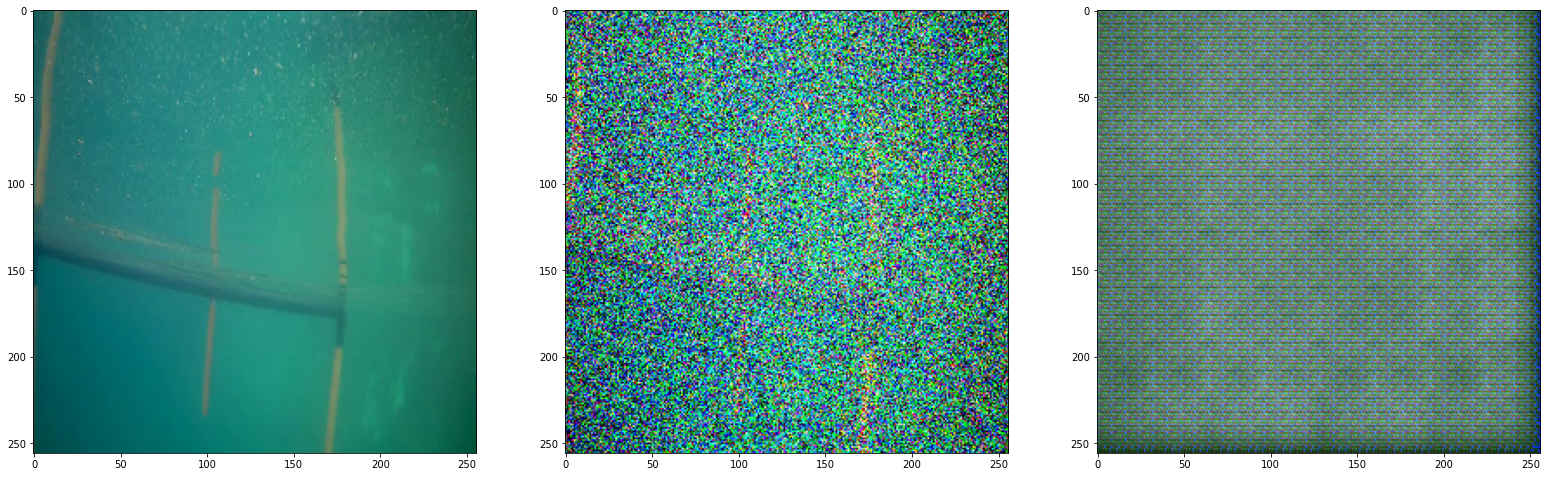

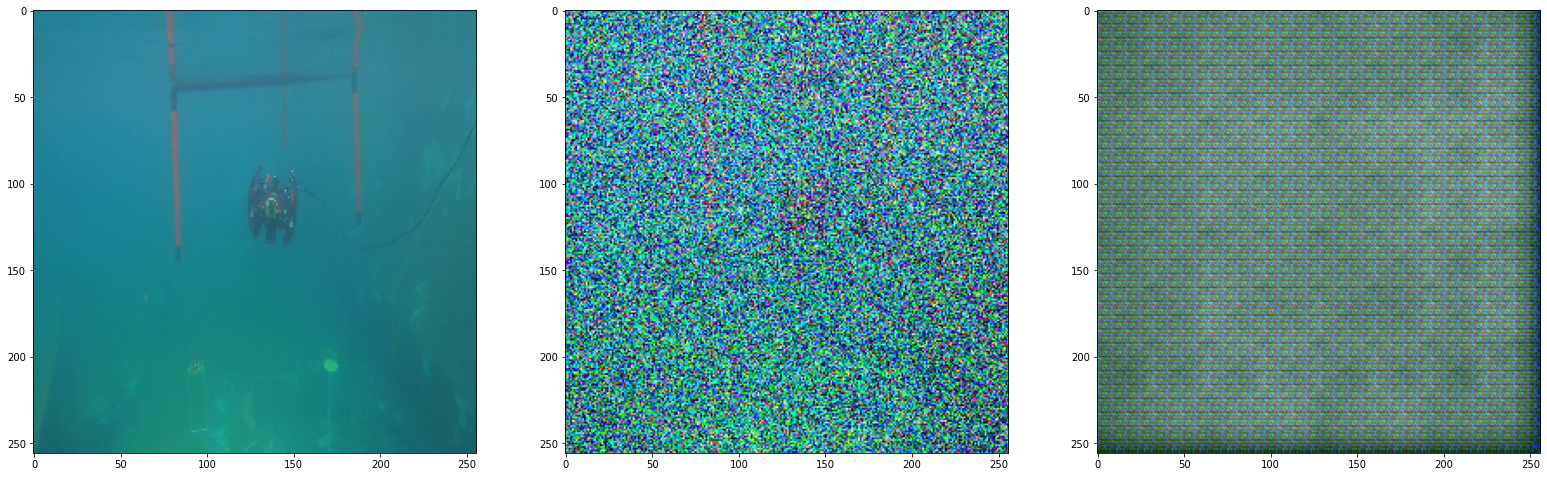

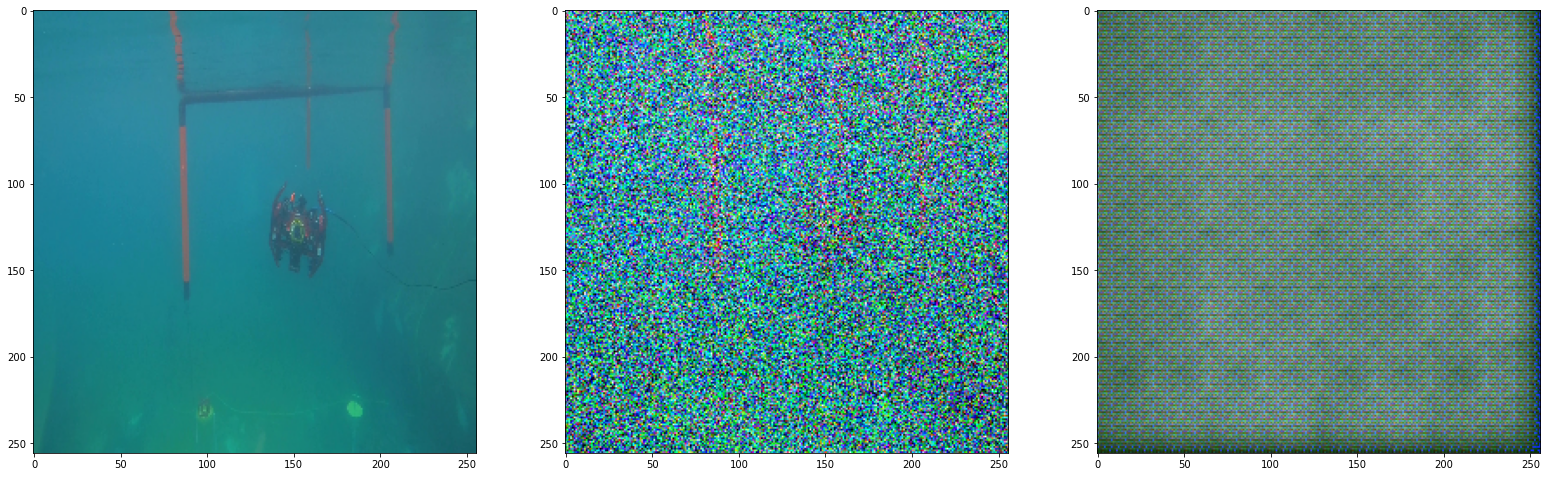

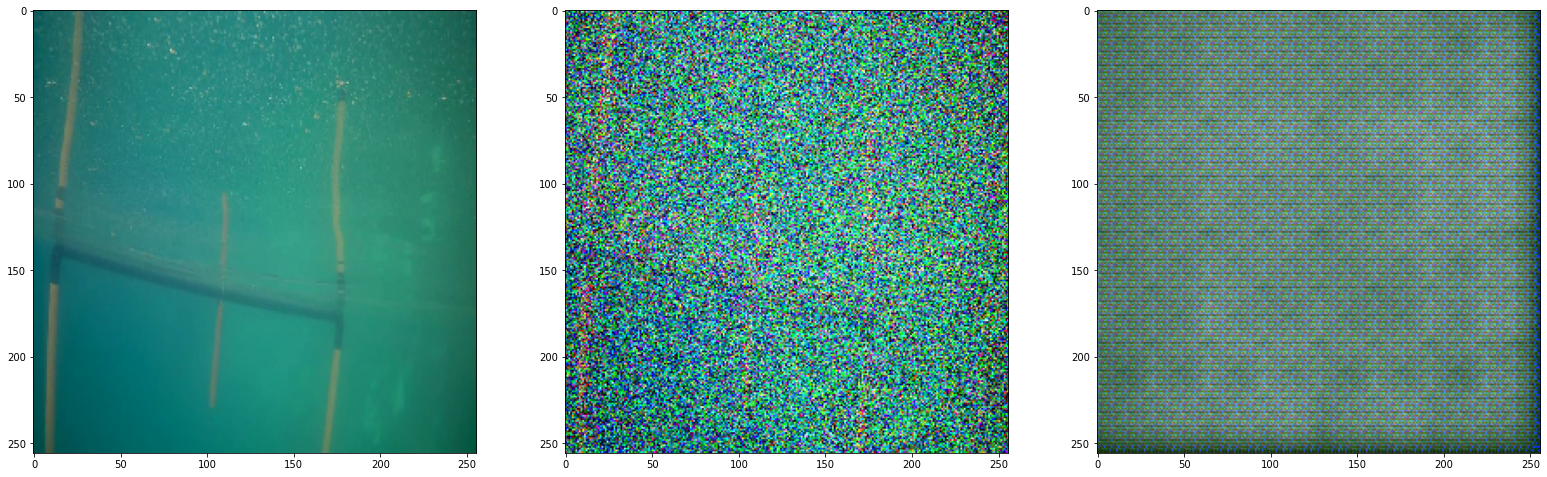

In [106]:
for output in outputs:
  images, labels, recons = output
  for k in range(len(images)):
    plt.figure(figsize = (27,9))
    image = np.transpose(images[k].numpy()*255, (1, 2, 0)).astype(np.uint8)
    label = np.transpose(labels[k].numpy()*255, (1, 2, 0)).astype(np.uint8)
    recon = np.transpose(recons[k].numpy()*255, (1, 2, 0)).astype(np.uint8)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(recon)

    
  break